# Train a neural network model on the active party's bank dataset

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append("../splitnn/")

from bank_dataset import BankDataset

manual_seed = 47
random.seed(manual_seed)
torch.manual_seed(manual_seed)

In [2]:
bank_set = BankDataset('../dataset/bank_additional_full_filtered_balanced_active.csv')
print(bank_set, len(bank_set))

x0, y0 = bank_set[0]
print("example sample data: ", x0)
print("example sample label: ", y0)
print(x0.shape, y0.shape)

Len(samples): 7718 Positive labels sum: 3859.0
<bank_dataset.BankDataset object at 0x7fa6d3541b50> 7718
example sample data:  tensor([1.2822e-01, 9.9990e-05, 1.0000e+00, 1.0000e+00, 9.9900e-04, 9.9900e-04,
        9.9900e-04, 9.9900e-04, 5.5560e-01, 7.5006e-01])
example sample label:  tensor(1.)
torch.Size([10]) torch.Size([])


In [3]:
# split the dataset into train_set and test_set
ratio = 0.2
test_len = int(len(bank_set) * 0.2)
total_len = int(len(bank_set))
train_len = total_len - test_len

train_set, test_set = torch.utils.data.random_split(bank_set, [train_len, test_len])
print("len(train_set):", len(train_set))
print("len(test_set):", len(test_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)
print("len(train_loader):", len(train_loader))
print("len(test_loader):", len(test_loader))

len(train_set): 6175
len(test_set): 1543
len(train_loader): 97
len(test_loader): 25


### Create the NN model for the bank dataset

In [4]:
input_size = x0.shape[0]
print("input_size = ", input_size)

class BankPreModel(nn.Module):
    """
    Define the model structure for the bank dataset
    """
    def __init__(self):
        super(BankPreModel, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.dense(x)

input_size =  10


In [5]:
def check_test_accuracy(model, dataloader, correct_base):
    correct = 0.0
    with torch.no_grad():
        for x, y in dataloader:
            y_hat = model(x)
            correct += ( (torch.zeros_like(y) + (y_hat > 0.5 ).squeeze() ) == y).sum()
    return correct / correct_base

### Train the NN model

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

my_model = BankPreModel()
optimizer = torch.optim.Adam(my_model.parameters())
loss_fn = torch.nn.BCELoss()
losses = []
train_accuracies = []
test_accuracies = []

epochs = 100

for epoch in range(epochs):
    correct = 0.0
    test_idx = 0
    train_correct_base = 0.0
    train_loss = 0.0
    for x, y in train_loader:
        # zero grads
        optimizer.zero_grad()

        # make prediction
        y_hat = my_model(x)

        # compute loss
        loss = loss_fn(y_hat, y)

        # back-propagation
        loss.backward()

        # update the weights
        optimizer.step()

        # compute the accuracy and record
        train_loss += loss
        correct += ( (torch.zeros_like(y) + (y_hat > 0.5 ).squeeze() ) == y).sum()
        test_idx += 1

        train_correct_base += x.shape[0]

    train = correct / train_correct_base
    train_accuracies.append(train)
    test = check_test_accuracy(my_model, test_loader, len(test_set))
    test_accuracies.append(test)
    print("In epoch {}, train accuracy is {}, test accuracy is {}.".format(epoch, train, test))
    losses.append(train_loss)

/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In epoch 0, train accuracy is 0.5760324001312256, test accuracy is 0.5819831490516663.
In epoch 1, train accuracy is 0.6029149889945984, test accuracy is 0.5800389051437378.
In epoch 2, train accuracy is 0.6093927025794983, test accuracy is 0.5806869864463806.
In epoch 3, train accuracy is 0.6090688109397888, test accuracy is 0.5800389051437378.
In epoch 4, train accuracy is 0.609554648399353, test accuracy is 0.5819831490516663.
In epoch 5, train accuracy is 0.6105263233184814, test accuracy is 0.5852236151695251.
In epoch 6, train accuracy is 0.6119837760925293, test accuracy is 0.5806869864463806.
In epoch 7, train accuracy is 0.6126315593719482, test accuracy is 0.5884640216827393.
In epoch 8, train accuracy is 0.6174898743629456, test accuracy is 0.5878159403800964.
In epoch 9, train accuracy is 0.6158704161643982, test accuracy is 0.5930006504058838.
In epoch 10, train accuracy is 0.6213765144348145, test accuracy is 0.598833441734314.
In epoch 11, train accuracy is 0.62429147958

### Plot the figures for illustration

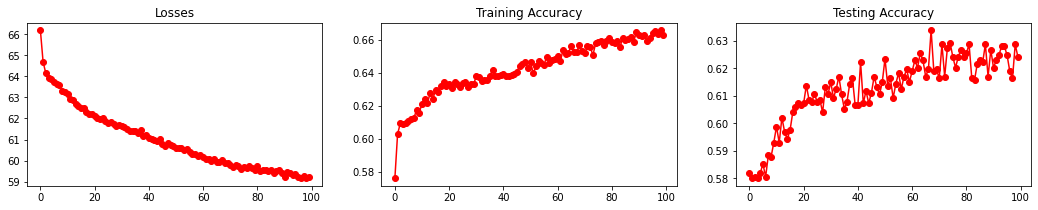

In [7]:
plt.figure(figsize=(18, 3))

plt.subplot(1, 3, 1)
plt.plot(range(len(losses)), losses, '-ro')
plt.title("Losses")
plt.subplot(1, 3, 2)
plt.plot(range(len(train_accuracies)), train_accuracies, '-ro')
plt.title("Training Accuracy")
plt.subplot(1, 3, 3)
plt.plot(range(len(test_accuracies)), test_accuracies, '-ro')
plt.title("Testing Accuracy")
plt.savefig("../tmp/bank-active.png")